In [1]:
!ls ../input/*

../input/competitive-data-science-predict-future-sales:
item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv

../input/pfs-dataprep:
__notebook__.ipynb  __results__.html   custom.css  mean_benchmark.csv
__output__.json     __results___files  data.h5	   prev_month_benchmark.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from math import sqrt
import pickle
import gc
import math
from tqdm import tqdm_notebook

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error

# Vowpal Wabbit is prominent for its training speed and support of many training modes, 
# especially for online learning with big and high-dimentional data.
from vowpalwabbit.sklearn_vw import VWRegressor

In [3]:
SEED = 42
DATA_PATH = '../input/pfs-dataprep/data.h5'
# Number of rows for tuning and training
TUNE_ROWS = 300000 # (~1 month)
TRAIN_ROWS = 2000000 # (~7 months)
# Months to reserve for ensembling methods
META_MONTHS = 4
EXCL_COLS = ['item_cnt_month']
HASH_COLS = ['item_id']
# All columns except *item_id* are static and hence OHE encoded
OHE_COLS = ['month', 'shop_id', 'item_category_id', 'city_id', 'type_id', 'subtype_id']
CAT_COLS = OHE_COLS + HASH_COLS
LRS = np.logspace(-2, 1, 10)

In [4]:
%%time
traintest = pd.read_hdf(DATA_PATH, key='traintest')

print(traintest.shape)

(7393103, 59)
CPU times: user 10.9 s, sys: 7.34 s, total: 18.3 s
Wall time: 18.6 s


In [5]:
tune_train_idx = traintest[traintest.date_block_num<33].sample(n=TUNE_ROWS, random_state=SEED).index
tune_valid_idx = traintest[traintest.date_block_num==33].index
# VW works well with randomly shuffled data
train_idx = traintest[traintest.date_block_num<34-META_MONTHS].sample(n=TRAIN_ROWS, random_state=SEED).index
test_idx = traintest[traintest.date_block_num>=34-META_MONTHS].index

print(len(tune_train_idx), len(tune_valid_idx), len(train_idx), len(test_idx))

300000 238172 2000000 1114452


### Preprocessing for linear models

In [6]:
numeric_features = traintest.columns.difference(['item_cnt_month', *CAT_COLS]).tolist()

traintest[OHE_COLS] = traintest[OHE_COLS].astype('category')
traintest[HASH_COLS] = traintest[HASH_COLS].astype(str)

In [7]:
def split_and_preprocess(train_idx, valid_idx):
    # Split data
    X_train = traintest.loc[train_idx].drop(EXCL_COLS, axis=1)
    y_train = traintest.loc[train_idx].item_cnt_month
    X_valid = traintest.loc[valid_idx].drop(EXCL_COLS, axis=1)
    y_valid = traintest.loc[valid_idx].item_cnt_month

    # Transformer to standard-scale the numerical features
    numeric_transformer = StandardScaler()

    # Shops and item categories are static in our dataset so OHE is sufficient
    # + vowpalwabbit's own algorithm uses global hashing space which may cause conflicts
    ohe_transformer = OneHotEncoder()

    # Vowpal Wabbit Transformer will encode items with hashing trick
    # For nominal data a hashing algorithm performs better than a binary or OHE algorithm

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('ohe', ohe_transformer, OHE_COLS)])

    # Perform transformations
    X_train = preprocessor.fit_transform(X_train).astype('float32')
    X_valid = preprocessor.transform(X_valid).astype('float32')
    
    return X_train, y_train, X_valid, y_valid

### Vowpal Wabbit

In [8]:
def rmse(y_true, y_pred):
    # Clipping required by the competition
    y_true = pd.Series(y_true).fillna(0).clip(0, 20).values
    y_pred = pd.Series(y_pred).fillna(0).clip(0, 20).values
    return sqrt(mean_squared_error(y_true, y_pred))

In [9]:
def setup_and_fit_model(train_set, eval_set, return_scores=False, **params):
    # Fit the Vowpal Wabbit regressor and return the scores 
    X_train, y_train = train_set
    X_valid, y_valid = eval_set
    vw = VWRegressor(random_seed=SEED, hash='strings', **params)
    vw.fit(X_train, y_train)
    train_score = rmse(y_train, vw.predict(X_train))
    valid_score = rmse(y_valid, vw.predict(X_valid))
    print("train_score {:.4f}, valid_score {:.4f}".format(train_score, valid_score))
    if return_scores:
        return train_score, valid_score
    return vw

In [10]:
def tune_lr(train_set, eval_set):
    # Find an optimal learning rate for the size of the dataset
    X_train, y_train = train_set
    X_valid, y_valid = eval_set
    train_scores = []
    valid_scores = []
    for lr in tqdm_notebook(LRS):
        print(f'lr {lr}')
        train_score, valid_score = setup_and_fit_model((X_train, y_train), (X_valid, y_valid), 
                                                       return_scores=True, learning_rate=lr)
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        # force the Garbage Collector to release unreferenced memory
        gc.collect()
        
    results = pd.DataFrame({'learning_rate': LRS, 'train_score': train_scores, 'valid_score': valid_scores})
    results.plot(x='learning_rate', y=['train_score', 'valid_score'])
    return LRS[np.argmin(valid_scores)]

In [11]:
%%time
X_train, y_train, X_valid, y_valid = split_and_preprocess(tune_train_idx, tune_valid_idx)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(300000, 308) (300000,) (238172, 308) (238172,)
CPU times: user 6.24 s, sys: 2.1 s, total: 8.34 s
Wall time: 8.35 s


lr 0.01
train_score 1.1567, valid_score 1.0806
lr 0.021544346900318832
train_score 1.1148, valid_score 1.0528
lr 0.046415888336127774
train_score 1.0643, valid_score 1.0186
lr 0.1
train_score 1.0194, valid_score 0.9873
lr 0.21544346900318834
train_score 0.9901, valid_score 0.9690
lr 0.46415888336127775
train_score 0.9715, valid_score 0.9637
lr 1.0
train_score 0.9661, valid_score 0.9692
lr 2.154434690031882
train_score 0.9708, valid_score 0.9829
lr 4.6415888336127775
train_score 0.9883, valid_score 1.0083
lr 10.0
train_score 1.0307, valid_score 1.0497



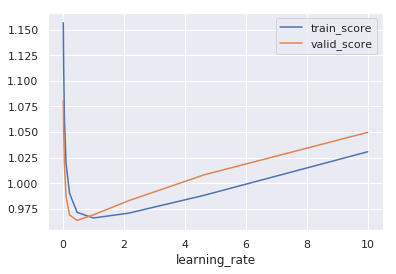

In [12]:
best_lr = tune_lr((X_train, y_train), (X_valid, y_valid))

In [13]:
# Simple trick: decrease learning rate while increasing the size of data
best_lr *= TUNE_ROWS / TRAIN_ROWS

print(best_lr)

0.06962383250419166


In [14]:
%%time
X_train, y_train, X_test, y_test = split_and_preprocess(train_idx, test_idx)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2000000, 306) (2000000,) (1114452, 306) (1114452,)
CPU times: user 31.2 s, sys: 25 s, total: 56.2 s
Wall time: 56.2 s


In [15]:
%%time
vw = setup_and_fit_model((X_train, y_train), (X_valid, y_valid), learning_rate=best_lr)

train_score 1.0078, valid_score 1.0063
CPU times: user 17min 22s, sys: 16.2 s, total: 17min 38s
Wall time: 17min 38s


In [16]:
def save_preds(preds, fname):
    preds = pd.Series(preds, index=test_idx)
    preds.to_csv(fname)
    print(preds.head())
    print(preds.describe()[['mean', 'std', 'min', 'max']])

In [17]:
vw_preds = vw.predict(X_test)

In [18]:
save_preds(vw_preds, 'vw_preds.csv')

6278651    0.020287
6278652    0.437298
6278653    0.000000
6278654    0.041613
6278655    0.214028
dtype: float64
mean     0.335109
std      0.612179
min      0.000000
max     15.822998
dtype: float64
